https://towardsdatascience.com/stock-price-prediction-intervals-using-monte-carlo-simulation-6b52b8ac9c27
https://gist.github.com/jkclem/b16f9d8cd0a9e817fd3baa3ce3cd0194

In [1]:
# imports datetime for picking beginning and end dates for the analysis
import datetime
# imports yahoo finance for getting historical stock prices
import yfinance as yf
# imports pandas for dataframe manipulation
import pandas as pd
# imports numpy
import numpy as np
# for data visualization
import matplotlib as mpl
# for changing the plot size in the Jupyter Notebook output
%matplotlib inline
# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)
# for shorter lines with plotting
from matplotlib import pyplot as plt
# to hide warning messages
import warnings
warnings.filterwarnings('ignore')

# sets the sample period as 5 years back from 09/12/2019
end = datetime.datetime(2019, 9, 12)
start = end - datetime.timedelta(days = 7*365)




<function matplotlib.pyplot.show(*args, **kw)>

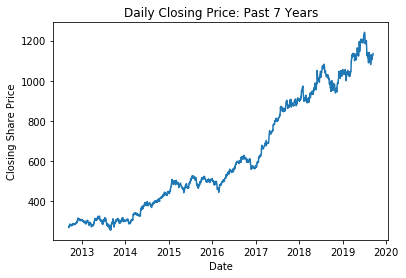

In [2]:
# gets the closing price fo Netflix for the past 5 years
my_stock = yf.Ticker('HDFCBANK.NS')
my_stock = pd.DataFrame(my_stock.history(start = start, end = end)['Close'])
my_stock = my_stock.rename(str.lower, axis = 'columns')

# grabs the last 100 observations, which will be reduced to 50 for the purpose of fitting a
# distribution for Monte Carlo simulation
my_stock_resid_distr_fitting = my_stock[-500:]
# creates a training subset missing the final 100 observations, which are being withheld
my_stock_train = my_stock[~my_stock.isin(my_stock_resid_distr_fitting).all(1)]
# grabs the final 50 observations for a test set
my_stock_test = my_stock_resid_distr_fitting[-250:]
# reduces the distribution fitting dataset to 50 observations
my_stock_resid_distr_fitting = my_stock_resid_distr_fitting[~my_stock_resid_distr_fitting.isin(my_stock_test).all(1)]

# plots the my_stock weekly closing price over the past 5 years
plt.plot(my_stock.index, my_stock.close)
plt.title('Daily Closing Price: Past 7 Years')
plt.xlabel('Date')
plt.ylabel('Closing Share Price')
plt.show

In [3]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [4]:
def tsplot(y, lags=None, figsize=(10, 8), style='seaborn-bright'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax, linewidth=1.5)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        
        plt.tight_layout()
    
    return

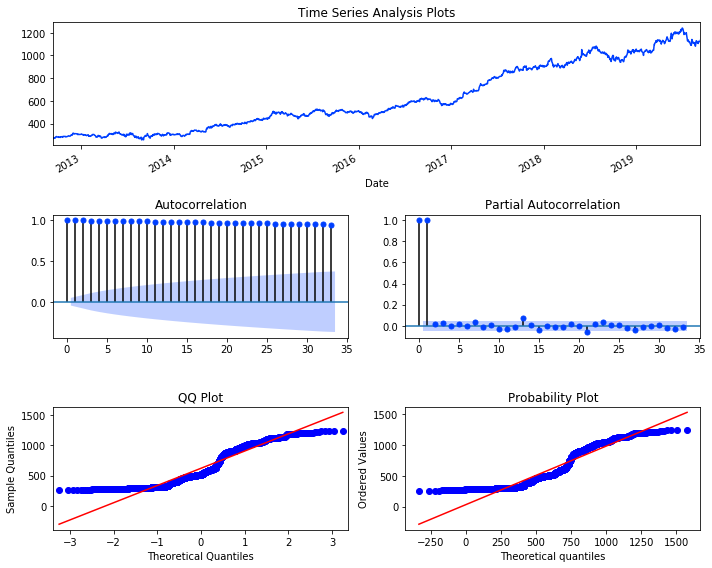

In [5]:
tsplot(my_stock.close)

In [6]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import coint

In [7]:
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
        
    def ADF_Stationarity_Test(self, timeseries, printResults = True, test_type='adfuller'):
        
        if test_type=='adfuller':
            
            #Dickey-Fuller test:
            adfTest = adfuller(timeseries, autolag='AIC')

            self.pValue = adfTest[1]

            if (self.pValue<self.SignificanceLevel):
                self.isStationary = True
            else:
                self.isStationary = False

            if printResults:
                dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])

                #Add Critical Values
                for key,value in adfTest[4].items():
                    dfResults['Critical Value (%s)'%key] = value

                print('####################################Augmented Dickey-Fuller Test Results:####################################')
                print(dfResults)
                print("Is the time series stationary? {0}".format(sTest.isStationary))
        if test_type =='adfuller':
            
            #Kwiatkowski-Phillips-Schmidt-Shin test for stationarity:
            kpssTest = kpss(timeseries)

            self.pValue = kpssTest[1]

            if (self.pValue<self.SignificanceLevel):
                self.isStationary = True
            else:
                self.isStationary = False

            if printResults:
                kpssResults = pd.Series(kpssTest[0:4], index=['KPSS Test Statistic','P-Value','# Lags Used','# Observations Used'])

                '''#Add Critical Values
                for key,value in kpssTest[4].items():
                    dfResults['Critical Value (%s)'%key] = value'''

                print('####################################KPSS Test Results:####################################')
                print(kpssResults)
                print("Is the time series stationary? {0}".format(sTest.isStationary))

In [16]:
sTest = StationarityTests()
#sTest.ADF_Stationarity_Test(my_stock.close, printResults = True)
#sTest.ADF_Stationarity_Test(my_stock.close.diff().dropna(), printResults = True)
my_stock['daily_ret']=my_stock.close.pct_change(1)
sTest.ADF_Stationarity_Test(my_stock.daily_ret.dropna(), printResults = True)



####################################Augmented Dickey-Fuller Test Results:####################################
ADF Test Statistic       -32.558829
P-Value                    0.000000
# Lags Used                1.000000
# Observations Used     1715.000000
Critical Value (1%)       -3.434169
Critical Value (5%)       -2.863227
Critical Value (10%)      -2.567668
dtype: float64
Is the time series stationary? True
####################################KPSS Test Results:####################################
KPSS Test Statistic                                             0.040041
P-Value                                                              0.1
# Lags Used                                                           25
# Observations Used    {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...
dtype: object
Is the time series stationary? False


/home/jesvinsebastian/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [23]:
my_stock.head()
my_stock.drop('daily_ret',axis=1,inplace=True)
my_stock.head()

,close
Date,
2012-09-13,268.92
2012-09-14,275.01
2012-09-17,273.01
2012-09-18,271.73
2012-09-20,272.38


In [33]:
def best_arima(df):
    # to suppress warnings
    warnings.filterwarnings('ignore')

    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(df, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    tsplot(best_mdl.resid, lags=30)
    from statsmodels.stats.stattools import jarque_bera

    score, pvalue, _, _ = jarque_bera(best_mdl.resid)
    if pvalue < 0.05:
        print("Our residuals are likely not normally distributed.")
    else:
        print("Our residuals are likely normally distributed.")

aic: 11682.34493 | order: (0, 1, 2)
Our residuals are likely not normally distributed.


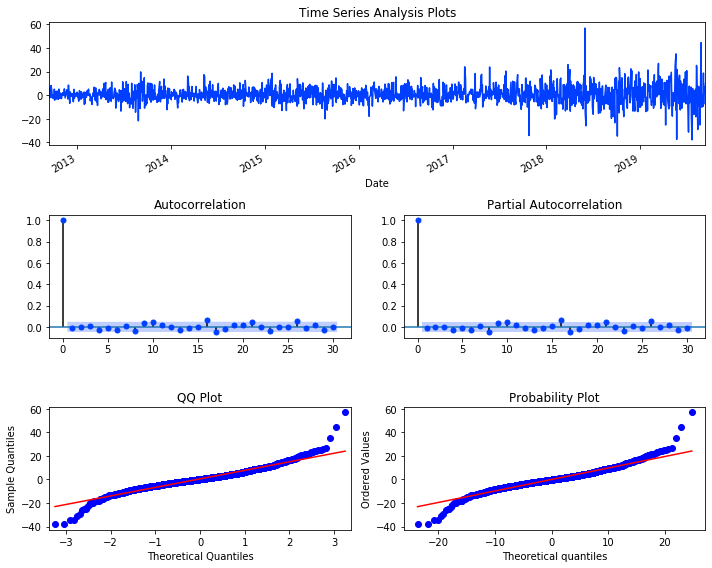

In [34]:
best_arima(my_stock.close)

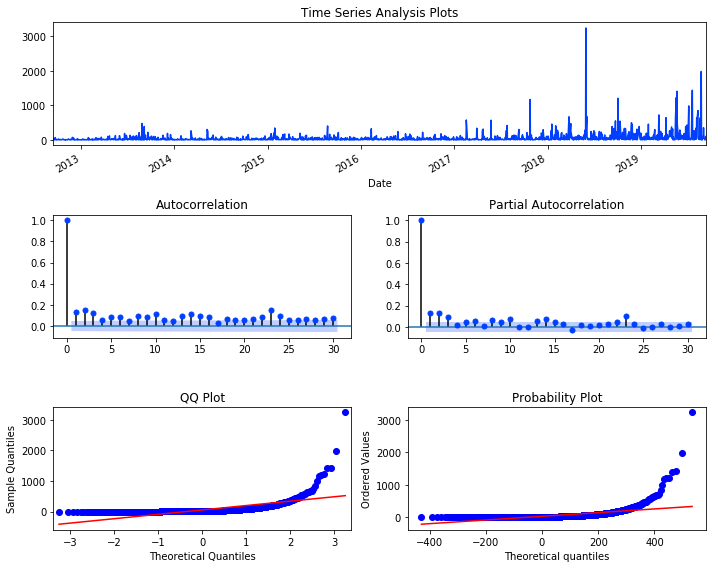

In [36]:
tsplot(best_mdl.resid**2, lags=30)

In [38]:
### Using the ARCH model function to model the volatility of the residuals
from arch import arch_model
vol_model = arch_model(best_mdl.resid)
res = vol_model.fit(update_freq=5)
print(res.summary())

ModuleNotFoundError: No module named 'arch'